In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

table = pd.read_csv("table.csv", sep = ";")
N = 10000
K = 11000

le = LabelEncoder()
le.fit(table.X12)
table["X12"] = le.transform(table.X12)
dct = {"/PhizIC/private/payments/confirm.do": 1, "/PhizIC/private/async/payments/confirm.do": 2, np.nan: -1}
table["X26"] = table["X26"].map(dct)
dct = {"Windows": 1, "Android": 2, "an unknown OS": 3, "Linux": 4, "Mac": 5, "iPhone/iPod":6, np.nan: -1}
table["X11"] = table["X11"].map(dct)
dct = {"F": 1, "G": 0, "U":0}
table["CLASS1"] = table["CLASS"].map(dct)

X = np.array([table["X9"].values[0:N], table["X10"].values[0:N], table["X11"].values[0:N], table["X12"].values[0:N],
            table["X13"].values[0:N], table["X14"].values[0:N], table["X15"].values[0:N], table["X17"].values[0:N],
            table["X18"].values[0:N], table["X22"].values[0:N], table["X26"].values[0:N]])
X = X.transpose()
y = table["CLASS1"][0:N].values

P = np.array([table["X9"].values[N:K], table["X10"].values[N:K], table["X11"].values[N:K], table["X12"].values[N:K],
            table["X13"].values[N:K], table["X14"].values[N:K], table["X15"].values[N:K], table["X17"].values[N:K],
            table["X18"].values[N:K], table["X22"].values[N:K], table["X26"].values[N:K]])
P = P.transpose()

#table["p0_Fraud"] = table.apply(lambda row: predict(row), axis=1)
#print(table["p0_Fraud"].unique())


clf = RandomForestClassifier(n_estimators=500, max_depth=5,
                             random_state=0)
clf.fit(X, y)  

print(clf.feature_importances_)

dct = {}
table["p0_Fraud"] = table["X26"].map(dct)

for i in range(N,K):
    p0 = clf.predict([P[i-N].tolist()])[0]
    table.loc[i, "p0_Fraud"] = p0
#print(table["p0_Fraud"][N:N+10])

[4.91631717e-02 2.69168361e-02 5.47998310e-02 4.19491111e-04
 2.03287603e-02 4.06471957e-02 4.23672105e-01 2.08975993e-01
 1.69560579e-02 5.60087011e-02 1.02111858e-01]


In [3]:
def falsepos(rule,percent):
    c1=c2=0
    for i in range(len(table[rule])):
        if (table["CLASS"][i]=="G"):
            c1+=1
            if (table[rule][i]>=percent):
                c2+=1
    print("fp: "+str(c2/c1))

def falseneg(rule,percent):
    c1=c2=0
    for i in range(len(table[rule])):
        if (table["CLASS"][i]!="G"):
            c1+=1
            if (table[rule][i]<=percent):
                c2+=1
    print("fn: "+str(c2/c1))

def recall(rule,percent):
    fsfr=fslr=lsfr=0
    q=len(table[rule])
    for i in range(q):
        if (table[rule][i]>=percent):
            if (table["CLASS"][i]!="G"):
                fsfr+=1
            else:
                fslr+=1
        else:
            if (table["CLASS"][i]!="G"):
                lsfr+=1
    print("recall: "+str(fsfr/(fsfr+q*lsfr)))
    print("precicion: "+str(fsfr/(fsfr+q*fslr)))

for p in range(0,1):
    rule="p"+str(p)+"_Fraud"
    print(rule+":")
    falsepos(rule,0.5)
    falseneg(rule,0.5)
    recall(rule,0.5)
    
#fp<=0.2 if:
#r1=0.69
#r2=0.79
#r3=0.54
#r4=0.53
#r5=0.99

p0_Fraud:
fp: 0.002562225475841874
fn: 0.02200392927308448
recall: 2.83924529777376e-07
precicion: 5.8496636443404506e-05


0.007240476190476186
0.10809047619047618
0.41449761904761906
0.10023809523809535


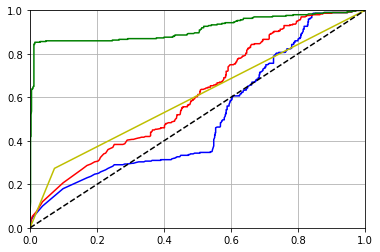

In [4]:
from sklearn.metrics import roc_curve, auc
import numpy as np

y = np.array(table["CLASS"][N:K])
x1 = np.array(table["p1_Fraud"][N:K])
x2 = np.array(table["p2_Fraud"][N:K])
x3 = np.array(table["p3_Fraud"][N:K])
x0 = np.array(table["p0_Fraud"][N:K])
fpr, tpr, thresholds = roc_curve(y,x1,pos_label="F")
roc_auc = auc(fpr,tpr)
print(roc_auc-0.5)
plt.plot(fpr, tpr, 'b')
fpr, tpr, thresholds = roc_curve(y,x2,pos_label="F")
roc_auc = auc(fpr,tpr)
print(roc_auc-0.5)
plt.plot(fpr, tpr, 'r')
fpr, tpr, thresholds = roc_curve(y,x3,pos_label="F")
roc_auc = auc(fpr,tpr)
print(roc_auc-0.5)
plt.plot(fpr, tpr, 'g')
fpr, tpr, thresholds = roc_curve(y,x0,pos_label="F")
roc_auc = auc(fpr,tpr)
print(roc_auc-0.5)
plt.plot(fpr, tpr, 'y')
plt.plot([0,1], [0,1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.show()